In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [2]:
def Sliding_Window(df_temp,win_len,stride):
    X=[]
    Y=[]
    T=[]

    for i in np.arange(0,len(df_temp)-(win_len),stride):
        temp = df_temp.iloc[i:i+win_len,[3,4]].values

        X.append(temp)
        Y.append(df_temp.iloc[i+win_len,-1])
        T.append(df_temp.iloc[i+win_len,0])

    return np.array(X),np.array(Y),np.array(T)

- The data imported from the Matlab-simulink model are in **csv format**, with name as "{Fault}_noise_02.csv"
- **M** number of such files are present, coresponding to **M** faults.
- In each fault file, the fault is introduced at **t=\[1000,1500\]s** for incipient fault and **t=\[2000,2500\]s** for the step fault.

The Goal is to extract only the values of residuals between t=\[1000,1500\]s and t=\[2000,2500\]s. These values are then stored in a **new DataFrame**, which contains the residual information for all the fault classes. 

In [3]:
working_cond = 40

Path = r'.\ALL_DC_motor_Data\Ua_{}V_Noise_2_perct'.format(working_cond) # Path of the folder containing CSV files from that working condition
file_name = os.listdir(path=Path) 

In [4]:
def PreprocessData(working_cond,win_len,stride):
    Path = r'.\ALL_DC_motor_Data\Ua_{}V_Noise_2_perct'.format(working_cond) # Path of the folder containing CSV files from that working condition
    file_name = os.listdir(path=Path) 


    X_full, Y_full = [], []

    for f in file_name : #Iterate through each file, which coresponds to a Fault
        csv_path =  os.path.join(Path,f)
        df = pd.read_csv(csv_path)

        temp_df_1=df[(df.time > 1050) & (df.time< 1500)]  # Incipient-Taking samples after which the Parameter fault was introduced

        x1, y1, _ = Sliding_Window(temp_df_1,win_len,stride)

        temp_df_2=df[(df.time > 2050) & (df.time< 2500)]  # Step -Taking samples after which the Parameter fault was introduced

        x2, y2, _ = Sliding_Window(temp_df_2,win_len,stride)

        x_temp, y_temp = np.concatenate((x1,x2),axis=0),np.concatenate((y1,y2),axis=0)

        X_full.append(x_temp)
        Y_full.append(y_temp)


    X_full = np.array(X_full)
    X_full = np.reshape(X_full, (-1,X_full.shape[2],X_full.shape[3]))

    Y_full = np.array(Y_full)
    Y_full = np.reshape(Y_full, (-1))

    return X_full, Y_full


In [5]:
WL=20
S=40

X_120, Y_120 = PreprocessData(working_cond=120,win_len=WL,stride=S)
X_80, Y_80  = PreprocessData(working_cond=80,win_len=WL,stride=S)
X_40, Y_40 = PreprocessData(working_cond=40,win_len=WL,stride=S)

In [6]:
X_full = np.concatenate((X_40,X_80,X_120))
Y_full = np.concatenate((Y_40,Y_80,Y_120))

print(f"length of total data = {len(X_full)}")

length of total data = 5376


In [7]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_full, train_size=200, random_state=42)

# Standardising the data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test_sc = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
# One Hot encoding
encoder = OneHotEncoder(sparse=False)
y_train_ohe = encoder.fit_transform(y_train.reshape(-1,1))
y_test_ohe = encoder.transform(y_test.reshape(-1,1))

# Hyper Parameter Tuning

In [16]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D

def build_model(hp):
    num_classes=len(encoder.categories_[0])
    # create model object
    model = Sequential([
    #adding first convolutional layer    
    Conv1D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=32),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=(X_train.shape[1],X_train.shape[2]),
        padding='same'),
    # adding second convolutional layer 
    MaxPooling1D(pool_size=2,padding='same'),
    # adding flatten layer    
    Flatten(),
    # adding dense layer    
    Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    # output layer    
    Dense(num_classes, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [31]:

#creating randomsearch object
tuner = kt.RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 10)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [32]:
# search best parameter
tuner.search(X_train_sc,y_train_ohe,epochs=20,validation_data=(X_test_sc,y_test_ohe))

Trial 10 Complete [00h 00m 08s]
val_accuracy: 0.9932380318641663

Best val_accuracy So Far: 0.9959428310394287
Total elapsed time: 00h 00m 48s
INFO:tensorflow:Oracle triggered exit


In [40]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 5
dense_1_units: 96
learning_rate: 0.001
Score: 0.9959428310394287
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 5
dense_1_units: 48
learning_rate: 0.01
Score: 0.995169997215271
Trial summary
Hyperparameters:
conv_1_filter: 16
conv_1_kernel: 3
dense_1_units: 80
learning_rate: 0.001
Score: 0.9932380318641663
Trial summary
Hyperparameters:
conv_1_filter: 80
conv_1_kernel: 5
dense_1_units: 64
learning_rate: 0.001
Score: 0.9930447936058044
Trial summary
Hyperparameters:
conv_1_filter: 48
conv_1_kernel: 3
dense_1_units: 96
learning_rate: 0.001
Score: 0.9922720193862915
Trial summary
Hyperparameters:
conv_1_filter: 48
conv_1_kernel: 3
dense_1_units: 80
learning_rate: 0.01
Score: 0.9922720193862915
Trial summary
Hyperparameters:
conv_1_filter: 16
conv_1_kernel: 5
dense_1_units: 64
learning_rate: 0.01
Score: 0.9922720193862915
Trial summary
Hy

In [33]:
cnn_model=tuner.get_best_models(num_models=1)[0]
#summary of best model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 112)           1232      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 112)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1120)              0         
                                                                 
 dense (Dense)               (None, 96)                107616    
                                                                 
 dense_1 (Dense)             (None, 8)                 776       
                                                                 
Total params: 109,624
Trainable params: 109,624
Non-trainable params: 0
__________________________________________________

# AI Training

In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,restore_best_weights=True)

cnn_model.fit(X_train_sc,
            y_train_ohe,
            epochs=200,
            batch_size=32,              
            validation_data=(X_test_sc, y_test_ohe),
            callbacks=[callback],
            shuffle=False,verbose=1)

Epoch 1/200
7/7 [==============================] - 1s 87ms/step - loss: 0.2857 - accuracy: 1.0000 - val_loss: 0.2638 - val_accuracy: 0.9909
Epoch 2/200
7/7 [==============================] - 0s 75ms/step - loss: 0.2108 - accuracy: 0.9950 - val_loss: 0.2003 - val_accuracy: 0.9774
Epoch 3/200
7/7 [==============================] - 0s 66ms/step - loss: 0.1563 - accuracy: 0.9850 - val_loss: 0.1583 - val_accuracy: 0.9687
Epoch 4/200
7/7 [==============================] - 0s 70ms/step - loss: 0.1200 - accuracy: 0.9900 - val_loss: 0.1271 - val_accuracy: 0.9724
Epoch 5/200
7/7 [==============================] - 0s 79ms/step - loss: 0.0946 - accuracy: 0.9900 - val_loss: 0.1065 - val_accuracy: 0.9772
Epoch 6/200
7/7 [==============================] - 0s 75ms/step - loss: 0.0772 - accuracy: 0.9950 - val_loss: 0.0928 - val_accuracy: 0.9789
Epoch 7/200
7/7 [==============================] - 1s 89ms/step - loss: 0.0649 - accuracy: 0.9950 - val_loss: 0.0828 - val_accuracy: 0.9803
Epoch 8/200
7/7 [===

In [35]:
from sklearn.metrics import f1_score


y_pred=cnn_model.predict(X_test_sc)
y_pred=encoder.inverse_transform(y_pred)

print(f"Train Sample = {len(X_train)} , The F1 score is- {f1_score(y_test,y_pred,average='weighted')}")


Train Sample = 200 , The F1 score is- 0.9910208261192033


# Real Time Fault Diagnosis

In [36]:
fault_label_dict = {'Healthy':0, 'I':3, 'I & W':7, 'K':5, 'Re':1, 'Re & Rm':6, 'Rm':2, 'W':4}

In [37]:
def Predict_CNN(fault_file, cnn_model, scaler, encoder, WL, S):
    '''fault_file = 'Healthy_noise_02.csv',
    'I & W_noise_02.csv',
    'I_noise_02.csv',
    'K_noise_02.csv',
    'Re & Rm_noise_02.csv',
    'Re_noise_02.csv',
    'Rm_noise_02.csv',
    'W_noise_02.csv'''
    csv_path =  os.path.join(Path,fault_file)
    df = pd.read_csv(csv_path)
    x1, y1, t1 = Sliding_Window(df,win_len=WL,stride=S)
    x_sc = scaler.transform(x1.reshape(-1,x1.shape[-1])).reshape(x1.shape)

    y_pred=cnn_model.predict(x_sc)
    y_pred=encoder.inverse_transform(y_pred)

    y_pred_num = np.vectorize(fault_label_dict.get)(y_pred)
    y_pred_num = y_pred_num.reshape(-1) 


    y_true_num = np.vectorize(fault_label_dict.get)(y1)
    y_true_num = y_true_num.reshape(-1) 

    return y_pred_num,y_true_num,t1

In [38]:
def plot_online_FDI(y_pred_num,y_true_num,t1):
    plt.subplots(figsize=(8,3))

    sns.scatterplot(x=t1,y=y_pred_num,hue=y_true_num,palette="bright",edgecolor='black',alpha=0.5,s=30)

    # Add labels and title
    plt.xlabel('time (s)',fontsize=10)
    plt.ylabel('Predicted fault class',fontsize=10)

    plt.yticks([0,1,2,3,4,5,6,7])
    plt.ylim([-.5,7.5])
    # ax.set_title('Line Plot of Dataset Size vs. Win Length')
    plt.legend(markerscale=1.5,bbox_to_anchor=(1.01, 1.05),title='Actual fault class',fontsize=10)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.axvspan(xmin=1000, xmax=1500, facecolor='r', alpha=0.2)
    plt.axvspan(xmin=2000, xmax=2500, facecolor='r', alpha=0.2)
    # Display the plot
    plt.show()

Introduced fault is Healthy


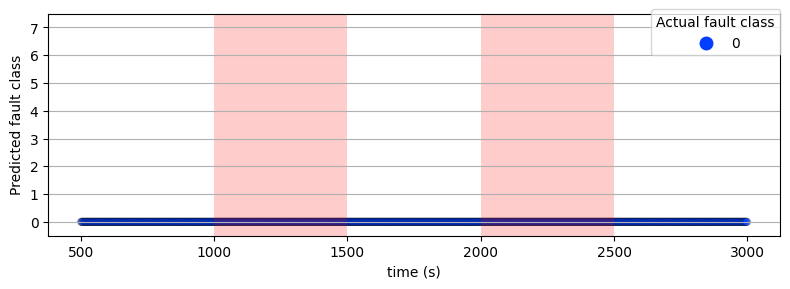

Introduced fault is I & W


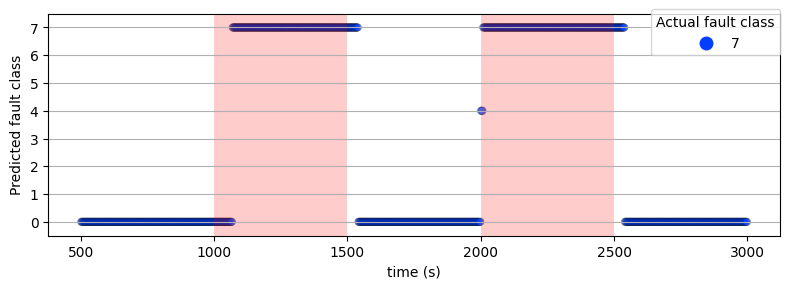

Introduced fault is I


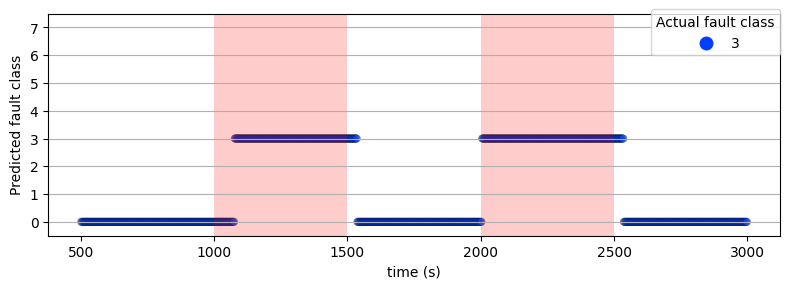

Introduced fault is K


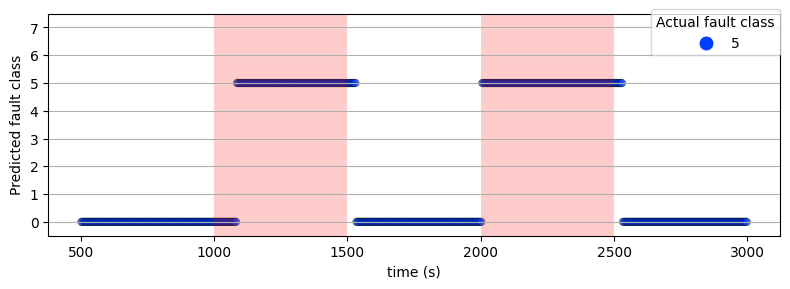

Introduced fault is Re & Rm


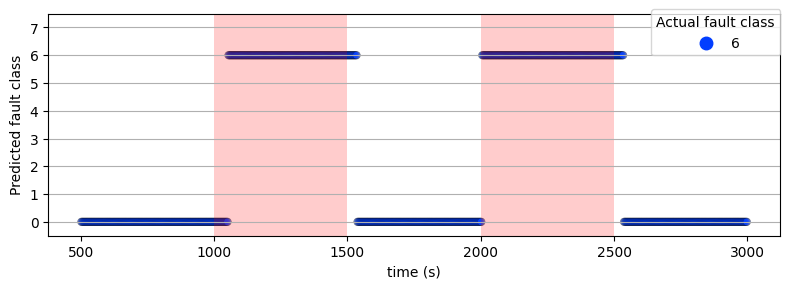

Introduced fault is Re


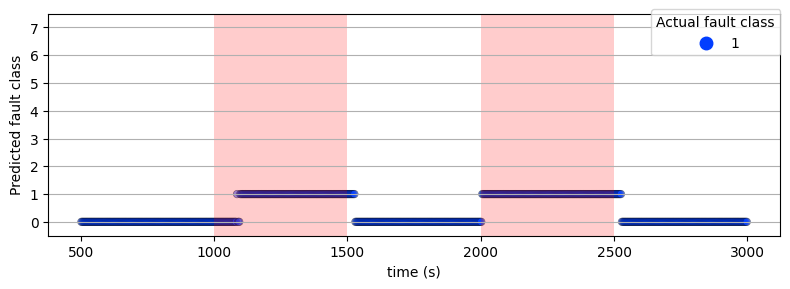

Introduced fault is Rm


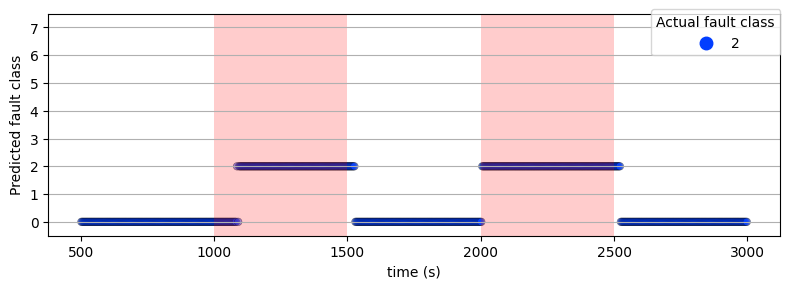

Introduced fault is W


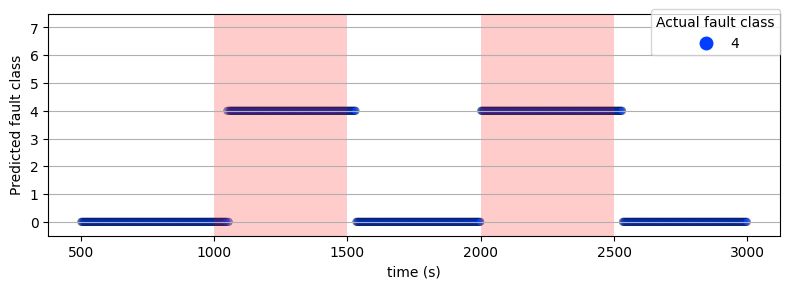

In [39]:
for f in file_name:
    print(f"Introduced fault is {f[:-13]}")
    y_pred_num,y_true_num,t1 = Predict_CNN(fault_file=f, cnn_model=cnn_model, scaler=scaler, encoder=encoder, WL=WL, S=S)
    plot_online_FDI(y_pred_num,y_true_num,t1)